In [3]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [4]:
os.listdir("./CKDU")

['test_data', 'train_data']

In [7]:
training_dataset_path = "./CKDU/train_data"

In [8]:
training_transforms = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

In [9]:
train_dataset = torchvision.datasets.ImageFolder(root=training_dataset_path,transform=training_transforms)

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=32,shuffle=False)

In [11]:
def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
        
    mean /= total_images_count
    std /= total_images_count
    
    return mean,std


In [12]:
get_mean_and_std(train_loader)

(tensor([0.4635, 0.4133, 0.3887]), tensor([0.2134, 0.2069, 0.2084]))

In [13]:
training_dataset_path = "./CKDU/train_data"
test_dataset_path = "./CKDU/test_data"

In [14]:
mean = [0.4635, 0.4133, 0.3887]
std = [0.2134, 0.2069, 0.2084]


train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
])



test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    
])

In [15]:
train_dataset = torchvision.datasets.ImageFolder(root=training_dataset_path, transform = train_transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_dataset_path, transform = test_transform)


In [16]:
def show_transformed_imgages(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle=True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images,  nrow = 3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid,(1,2,0)))
    print('labels: ',labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([0, 0, 0, 0, 0, 0])


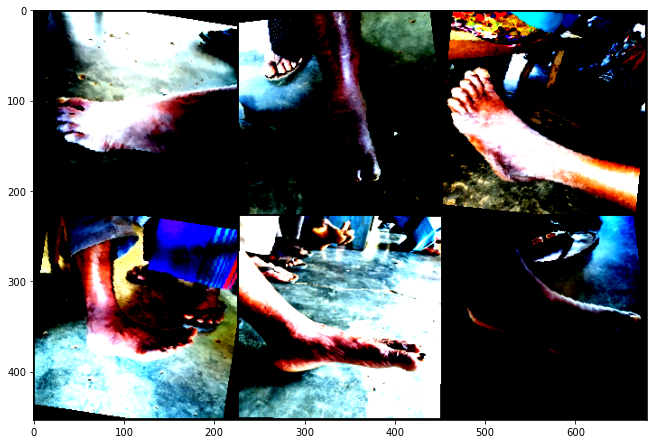

In [64]:
show_transformed_imgages(train_dataset)

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32,shuffle=True)


In [18]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

In [19]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    
    for epoch in range( n_epochs):
        print(f"Epoch number %d " % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
            
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total
        
        print("   - Training Dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss : %.3f" % (running_correct, total, epoch_acc, epoch_loss))
        
        evaluate_model_on_test_set(model, test_loader)
        
    print('Finished')
    return model
        

In [20]:
def evaluate_model_on_test_set(model,test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            predicted_correctly_on_epoch += (predicted == labels).sum().item()
    
    epoch_acc = 100.0 * predicted_correctly_on_epoch / total
    print("   - Testing dataset. GOt %d out ot %d images correctly (%.3f%%)" % (predicted_correctly_on_epoch, total, epoch_acc))

In [21]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(pretrained=False)
num_features = resnet18_model.fc.in_features
number_of_classes = 2
resnet18_model.fc = nn.Linear(num_features, number_of_classes)
device = set_device()
resnet18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)



C:\Users\DELL\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\DELL\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [22]:
train_nn(resnet18_model,train_loader,test_loader,loss_fn,optimizer,10)

Epoch number 1 
   - Training Dataset. Got 90 out of 90 images correctly (100.000%). Epoch loss : 0.129
   - Testing dataset. GOt 8 out ot 8 images correctly (100.000%)
Epoch number 2 
   - Training Dataset. Got 90 out of 90 images correctly (100.000%). Epoch loss : 0.001
   - Testing dataset. GOt 8 out ot 8 images correctly (100.000%)
Epoch number 3 
   - Training Dataset. Got 90 out of 90 images correctly (100.000%). Epoch loss : 0.000
   - Testing dataset. GOt 8 out ot 8 images correctly (100.000%)
Epoch number 4 
   - Training Dataset. Got 90 out of 90 images correctly (100.000%). Epoch loss : 0.000
   - Testing dataset. GOt 8 out ot 8 images correctly (100.000%)
Epoch number 5 
   - Training Dataset. Got 90 out of 90 images correctly (100.000%). Epoch loss : 0.000
   - Testing dataset. GOt 8 out ot 8 images correctly (100.000%)
Epoch number 6 
   - Training Dataset. Got 90 out of 90 images correctly (100.000%). Epoch loss : 0.000
   - Testing dataset. GOt 8 out ot 8 images correct

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  